In [1]:
#| label: app:interactive_sns_fig4

%matplotlib widget

from src.cdk.analysis.cytosol import platereader as pr
import pandas as pd

import seaborn as sns
import seaborn.objects as so

import matplotlib.pyplot as plt
import matplotlib as mpl

import timple
import timple.timedelta

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Output

import src.cdk.logging

pr.plot_setup()

# load data and calculat SS values
data, platemap = pr.load_platereader_data("tests/test_data/cytation_dna_sweep.txt", "tests/test_data/platemap.csv")
kinetics = pr.kinetic_analysis(data);

def plot_kinetics_wrapper(well, annotate=True):
    plt.clf()
    well_df = data[data['Well'] == well]
    pr.plot_kinetics_by_well(well_df, kinetics, annotate=annotate)

# Create widgets for the parameters
toggle = widgets.ToggleButtons(
    options=data['Well'].unique().tolist(),
    description='Well:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)

# Use interact to link the widgets to the plotting function
my_widget = widgets.interact(plot_kinetics_wrapper, well=toggle)

Failed to solve: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Failed to solve: Optimal parameters not found: Number of calls to function has reached maxfev = 800.


interactive(children=(ToggleButtons(description='Well:', options=('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B…

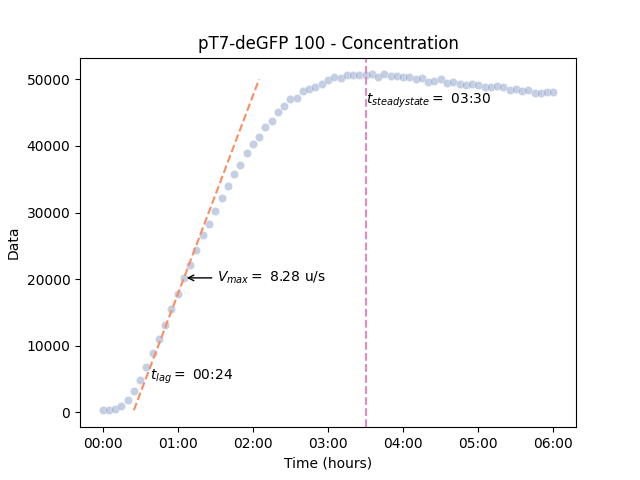